In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import seaborn
import geopandas as gp
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset
import state_set

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)
importlib.reload(state_set)

from matrix_operation import mat_opr
from Dataset import dataset
from state_set import state_data
from state_set import state_test_data

### Import data

In [3]:
state_dset = state_data(get_state_dat= True)

In [4]:
# I'm dropping Virgin Islands, Guam, Puerto Rico becuase unfortunately the data is a bit inconsistent
state_dset = mat_opr(state_dset.dataframe.drop(["Virgin Islands", "Guam", "Puerto Rico"],axis = 1)) #"Alaska",'Hawaii', 'Puerto Rico'], axis = 1))

### Iso + Normalize

In [5]:
# ia0 and normalize:
state_iso = state_dset.known_iso()
state_norm = state_iso.normalizer()

### Choose a Rank:

In [6]:
state_errors = []
for i in range(15):
    nmfed = state_norm.sci_nmf(components=i+1)
    state_errors.append(state_norm.mean_square_error(nmfed, 0))

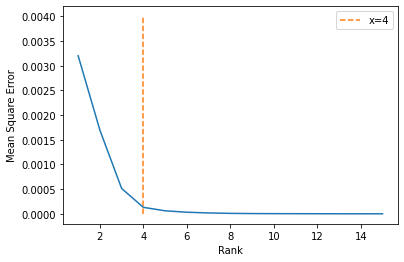

In [7]:
plt.plot(list(range(1,16)), state_errors)
plt.vlines(x=4, ymin=0, ymax= 0.0040, color="tab:orange", linestyle='dashed', label="x=4")
plt.xlabel("Rank")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()

In [8]:
state_ranker = 4

In [9]:
W,H = state_norm.sci_nmf(state_ranker, separate=True)
dotted = pd.DataFrame(np.dot(W,H))
dotted.index = state_norm.dataframe.index
dotted.columns = state_norm.dataframe.columns
state_nmf = mat_opr(dotted)

<AxesSubplot:title={'center':'Massachusetts Cases'}>

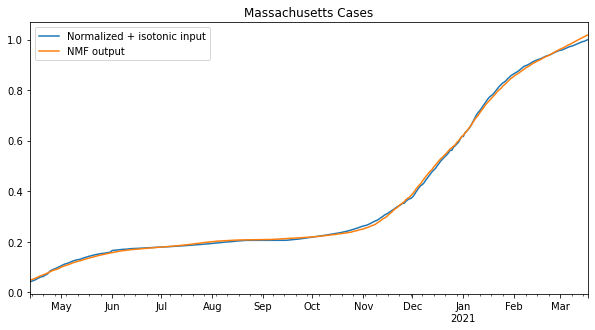

In [10]:
mass = pd.concat([state_norm.dataframe['Massachusetts'], state_nmf.dataframe['Massachusetts']], axis = 1)
mass.columns = ['Normalized + isotonic input','NMF output']

mass.plot(kind = 'line',legend=True, title = 'Massachusetts Cases', figsize=(10,5))

## Clustering:

In [11]:
def sort_by_cluster(labels):
    #helper function to see which columns are in which cluster
    cluster_dict = {lab:[] for lab in labels.value_counts().index}
    for i in range(len(labels)):
        cluster_dict[labels[i]].append(i) 
    return cluster_dict

In [12]:
def plot_cluster(data_obj, labels, mean = False, sample_size = 10,legend=False, 
                 ylimit=None, axer=None, ylabel=None, title = None):
    
    # plots a sample of data (or the mean of that sample) based on clustering results
    subs = labels.value_counts()
    if axer is None:
        fig, axer = plt.subplots(len(subs), figsize=(14,12))
        
    if ylimit is not None:
        for a in axer:
            a.set_ylim(ylimit)     
            
    clust_dict = sort_by_cluster(labels)
    

    for i in clust_dict.keys():
        if sample_size > len(clust_dict[i]):
            for j in clust_dict[i]:
                data_obj.dataframe.iloc[:,j].plot(ax=axer[i], legend = legend)
        else:
            samples = random.sample(clust_dict[i], sample_size)
            for j in samples:
                data_obj.dataframe.iloc[:,j].plot(ax=axer[i], legend=legend)
        if title is not None:
            axer[i].set_title("Cluster " + str(i) + " " + title)
        else:
            axer[i].set_title("Cluster " + str(i))
            
        if ylabel is not None:
            axer[i].set_ylabel(ylabel)
            
    if mean:
        for k in clust_dict.keys():
            meaner = data_obj.dataframe.iloc[:,clust_dict[k]].mean(axis=1)
            meaner.plot(ax=axer[k], color='k', linewidth=4.0, label='center', legend=legend)

In [13]:
#kmeans = KMeans(n_clusters=3, random_state=9).fit(np.transpose(np.array(state_norm.array)))
#counto = pd.Series(kmeans.labels_)
#plot_cluster(state_norm, counto,mean=True)

### Determine best # of clusters

In [14]:
indexer = []
for i in range(state_ranker):
    indexer.append("basis " + str(i))

In [15]:
h_table = mat_opr(pd.DataFrame(H, index = indexer))
h_clust = np.transpose(np.array(h_table.array))

For n_clusters = 2 The average silhouette_score is : 0.3535626298065381
For n_clusters = 3 The average silhouette_score is : 0.43573613171387593
For n_clusters = 4 The average silhouette_score is : 0.3336649042493108
For n_clusters = 5 The average silhouette_score is : 0.31732479934106583


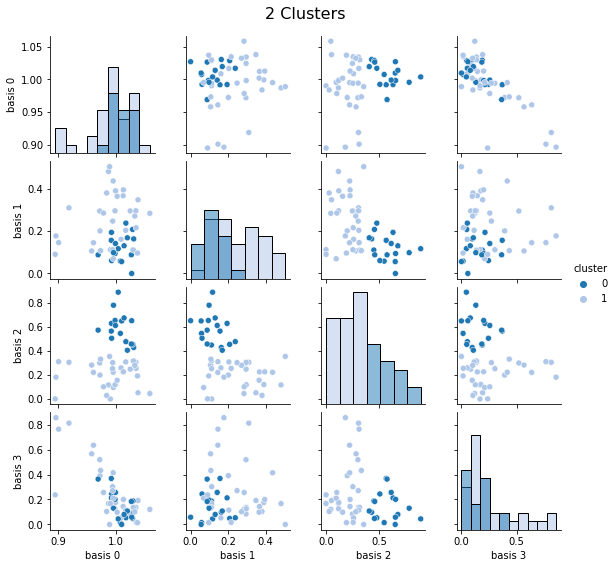

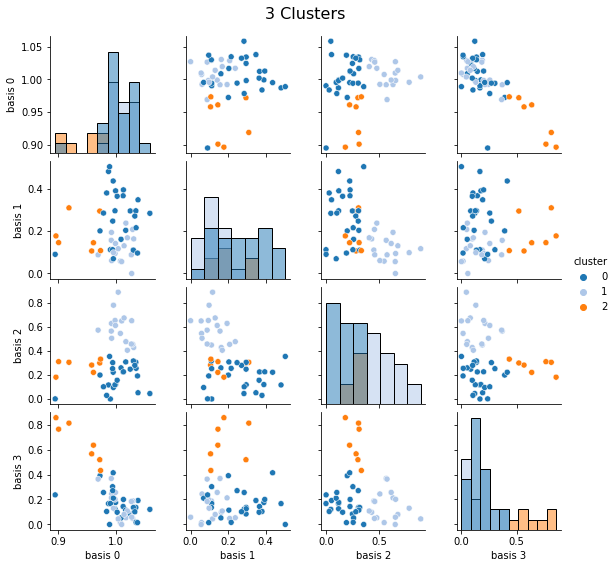

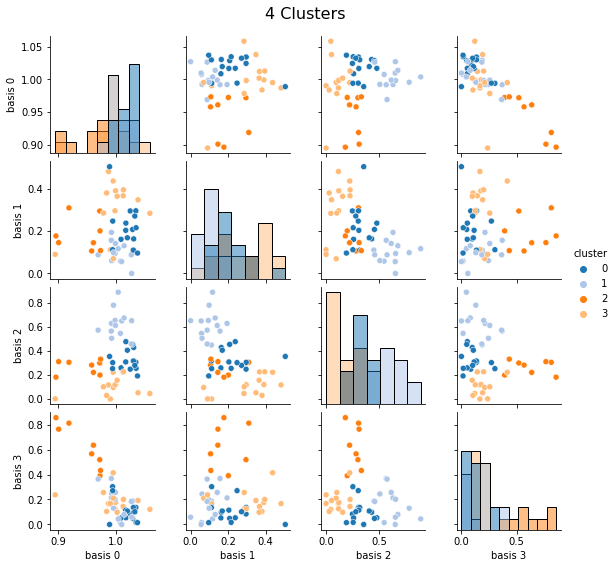

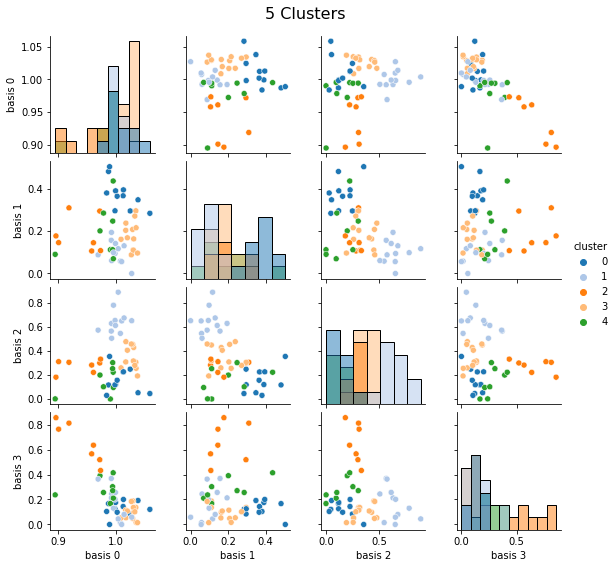

In [16]:
ns = [2,3,4,5]
silhouette = {}

for n in ns:
    kmeans = KMeans(n_clusters=n, random_state=9).fit(h_clust)
    n_counter = pd.Series(kmeans.labels_)
    
    silhouette_avg = silhouette_score(h_clust, n_counter)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    silhouette[n] = silhouette_avg
    
    n_cluster_df = h_table.dataframe.T
    n_cluster_df['cluster'] = n_counter

    pp = seaborn.pairplot(n_cluster_df, hue="cluster", diag_kind="hist", height=2, aspect=1, palette='tab20')
    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle(str(n) + " Clusters", fontsize=16)

In [17]:
# Take the number of clusters to be the max silhouette score
n_clusters = max(silhouette, key=silhouette.get)

In [18]:
kmeans = KMeans(n_clusters=n_clusters, random_state=9, max_iter = 1000).fit(h_clust)
counti = pd.Series(kmeans.labels_)

In [19]:
print(counti.value_counts().to_list())

[26, 18, 7]


### Pairwise distance matrix:

In [20]:
# This takes a while because I did the simple O(n^2) implementation
input_pair_dist = state_norm.pairwise_distance()
factor_pair_dist =  h_table.pairwise_distance()

In [21]:
# rearrange pair_dist so that all columns/rows belonging to cluster 0 come before the ones correspoinding to cluster 1, etc.
# graph and expect to see small distance on the diagonals and larger everywhere else

input_pair_dist.columns = range(len(input_pair_dist.columns))

order = []
for h in range(n_clusters):
    order += counti.loc[counti == h].index.to_list()

input_pair_dist = input_pair_dist[order]
input_pair_dist = input_pair_dist.reindex(order)
factor_pair_dist = factor_pair_dist[order]
factor_pair_dist = factor_pair_dist.reindex(order)

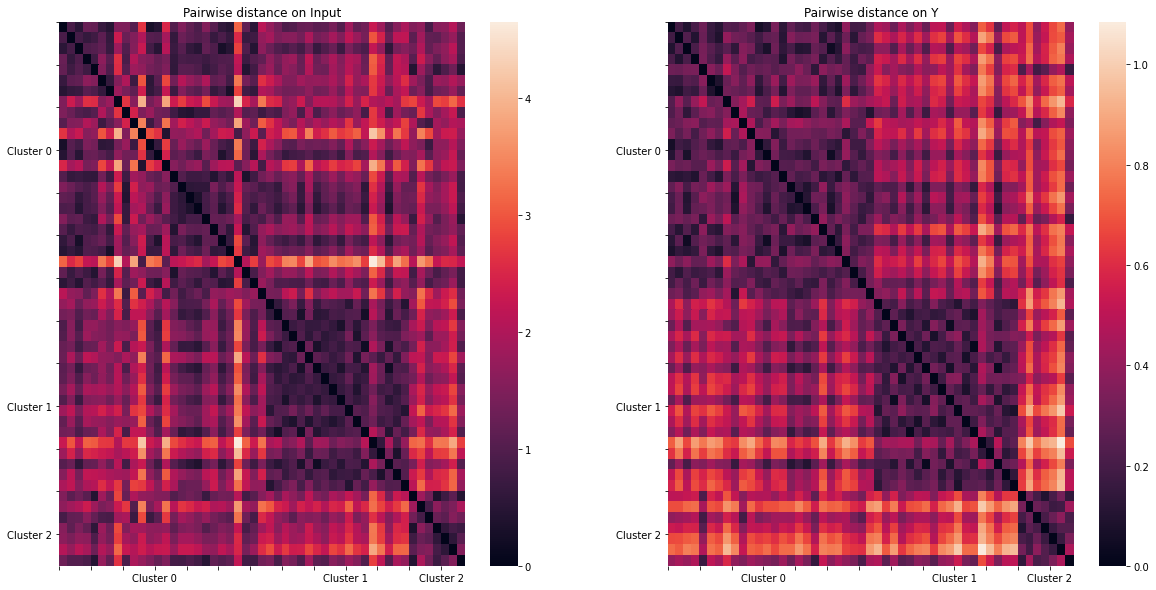

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
seaborn.heatmap(input_pair_dist, ax = ax1)
seaborn.heatmap(factor_pair_dist, ax = ax2)

# lot of work to get the x/yticks nice
tot = len(input_pair_dist.columns)
fracs = [va/tot for va in counti.value_counts().to_list()]
#l_m = round(np.lcm.reduce(counti.value_counts().to_list())/tot)

for axy in [ax1, ax2]:
    axy.xaxis.set_major_locator(plt.MaxNLocator(14))
    axy.yaxis.set_major_locator(plt.MaxNLocator(14))

so_far = 0
labs = ['' for i in range(14)]
for f in range(len(fracs)):
    pos = round(14*(fracs[f]/2 + so_far))
    labs[pos - 1] = 'Cluster ' + str(f)
    so_far += fracs[f]


ax1.set_xticklabels(labs, rotation= 0);
ax2.set_xticklabels(labs, rotation= 0);
ax1.set_yticklabels(labs);
ax2.set_yticklabels(labs);

ax1.set_title('Pairwise distance on Input');
ax2.set_title('Pairwise distance on Y');

### Clustering results for the vectors of Y after decomposition:

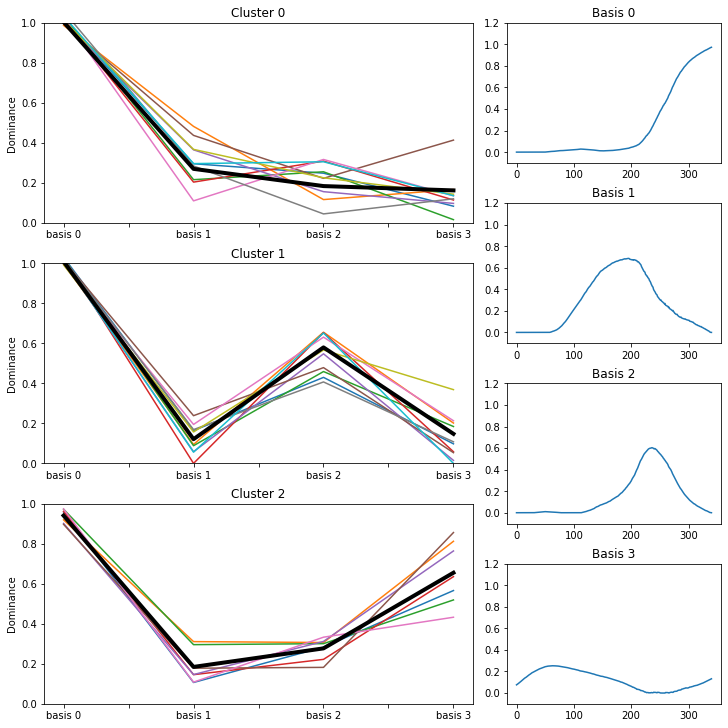

In [23]:
basis_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))

gs = basis_fig.add_gridspec(12,3)
bx1 = basis_fig.add_subplot(gs[:4,0:2])
bx2 = basis_fig.add_subplot(gs[4:8,0:2])
bx3 = basis_fig.add_subplot(gs[8:12,0:2])
bx4 = basis_fig.add_subplot(gs[:3,2])
bx5 = basis_fig.add_subplot(gs[3:6,2])
bx6 = basis_fig.add_subplot(gs[6:9,2])
bx7 = basis_fig.add_subplot(gs[9:12,2])
plot_cluster(h_table, counti, mean=True, ylimit = [0,1],axer=[bx1, bx2, bx3],
            ylabel = "Dominance")

baser = pd.DataFrame(W)
basis_subs = [bx4, bx5, bx6, bx7]
for b in baser.columns:
    baser[b].plot(ax = basis_subs[b], title="Basis " + str(b))
    basis_subs[b].set_ylim([-0.1,1.2])
    

### Plot the case curves based on clusters of Y

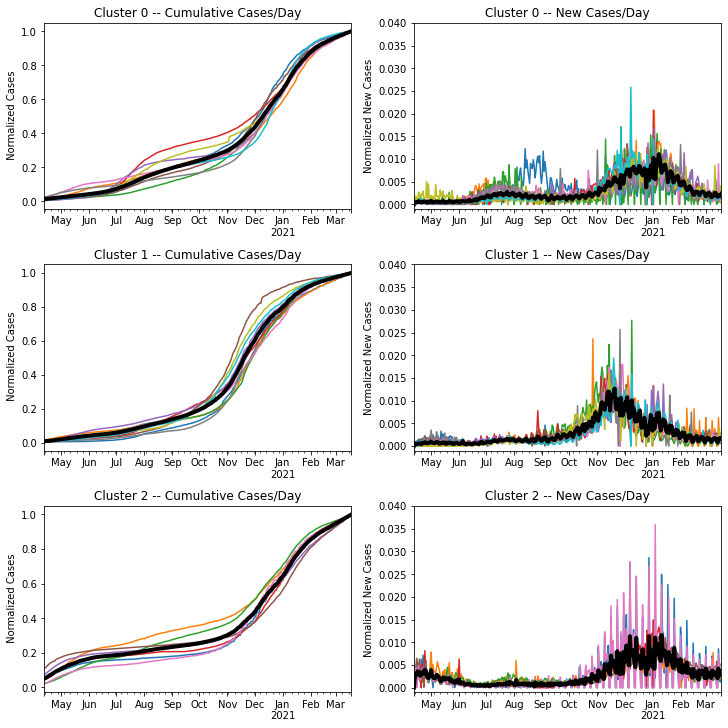

In [24]:
case_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))
cs = case_fig.add_gridspec(3,2)
cx1 = case_fig.add_subplot(cs[0,0])
cx2 = case_fig.add_subplot(cs[1,0])
cx3 = case_fig.add_subplot(cs[2,0])
cx4 = case_fig.add_subplot(cs[0,1])
cx5 = case_fig.add_subplot(cs[1,1])
cx6 = case_fig.add_subplot(cs[2,1])

plot_cluster(state_norm, counti, mean=True,axer=[cx1, cx2, cx3], 
             ylabel = " Normalized Cases", title = "-- Cumulative Cases/Day")
plot_cluster(state_norm.new_case_calc(), counti, mean=True, legend=False, 
             ylimit = [-0.001,.04],axer=[cx4,cx5,cx6], ylabel = "Normalized New Cases",
            title = "-- New Cases/Day")
plt.show()

### Geographical correlation? 

In [25]:
cluster_by_state = {}
for c in counti.index:
    s_name = state_norm.dataframe.iloc[:,c].name
    cluster_by_state[s_name] = counti[c]

In [26]:
state_map = gp.read_file("US_States_geojson.json")

In [27]:
cluster_col = []
for i in state_map["NAME"]:
    try:
        cluster_col.append("Cluster " + str(cluster_by_state[i]))
    except:
        cluster_col.append(np.nan)


In [28]:
state_map['cluster'] = cluster_col

<AxesSubplot:>

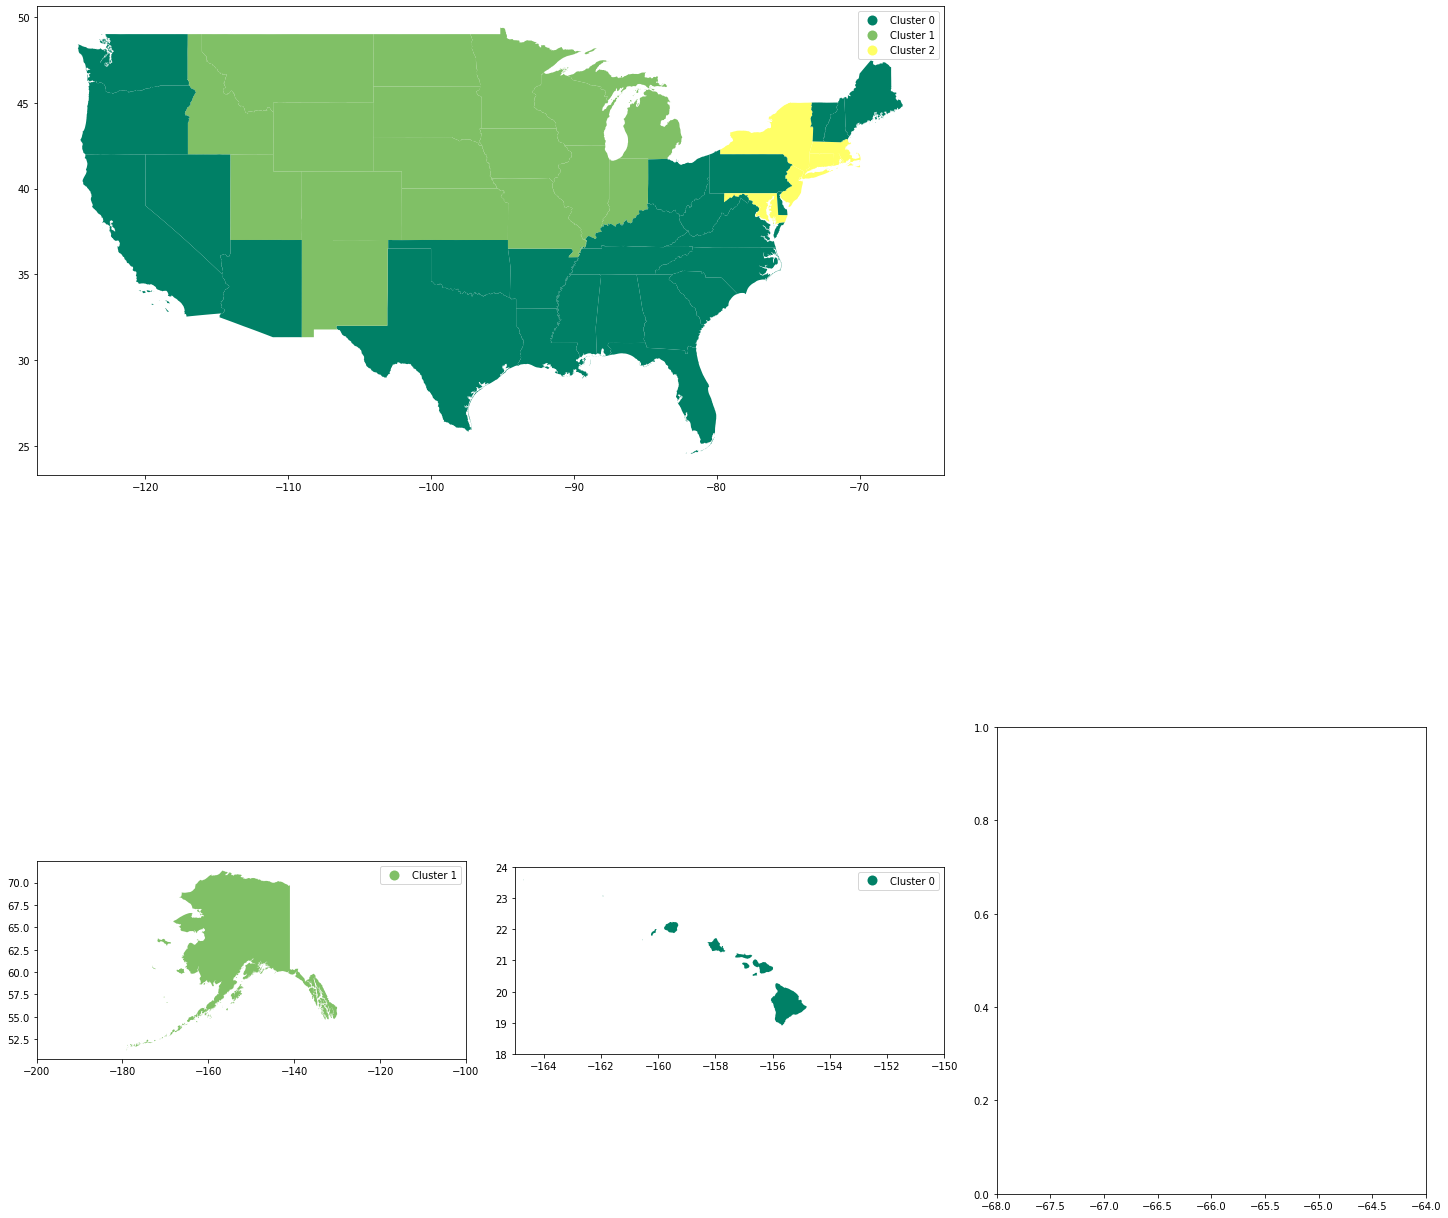

In [29]:
state_fig = plt.figure(1,constrained_layout=True, figsize=(20,20))
ss = state_fig.add_gridspec(3,3)
sx1 = state_fig.add_subplot(ss[0:2,0:2])
sx2 = state_fig.add_subplot(ss[2,0])
sx2.set_xlim(-200,-100)
sx3 = state_fig.add_subplot(ss[2,1])
sx3.set_xlim(-165,-150)
sx3.set_ylim(18,24)
sx4 = state_fig.add_subplot(ss[2,2])
sx4.set_xlim(-68,-64)

c0 = ListedColormap((0.0,0.5,0.4,1.0))
c1 = ListedColormap((0.5019607843137255, 0.7509803921568627, 0.4, 1.0))
c2 = ListedColormap((0.00392156862745098, 0.5019607843137255, 0.4, 1.0))

#state_map[state_map['NAME'].isin(['Alaska','Hawaii','Puerto Rico']) == False].plot(column='cluster', 
state_map[state_map['NAME'].isin(['Alaska','Hawaii']) == False].plot(column='cluster',
ax=sx1, legend=True, categorical=True, figsize=(60,60), cmap='summer')
state_map[state_map['NAME'] == 'Alaska'].plot(column='cluster', ax=sx2, legend=True, categorical=True, figsize=(10,10), cmap=c1)
state_map[state_map['NAME']=='Hawaii'].plot(column='cluster', ax=sx3, legend=True, categorical=True, figsize=(10,10), cmap=c0)
#state_map[state_map['NAME']=='Puerto Rico'].plot(column='cluster', ax=sx4, legend=True, categorical=True, figsize=(10,10), cmap=c0)


# Same Process with Positive Testing Rates (# cases / # tests per 100,000):

In [30]:
test_data = state_test_data(get_test_dat=True)
test_div = test_data.dataframe.drop(["Virgin Islands", "Guam", "Puerto Rico"],axis = 1)
test_div = test_div.replace(0, np.nan)
test_div = test_div.fillna(method='ffill', axis = 0)
test_rates = state_dset.dataframe.astype(float) / test_div

In [31]:
test_dset = mat_opr(test_rates)

### Normalization

In [32]:
# No missing values
test_dset.dataframe.isna().values.any()

False

In [33]:
#t_inp = mat_opr(test_dset.dataframe)
test_dset = test_dset.normalizer(maxer=True)

### Choose a rank

In [34]:
test_errors = []
for i in range(15):
    nmfed = test_dset.sci_nmf(components=i+1)
    test_errors.append(test_dset.mean_square_error(nmfed, 0))

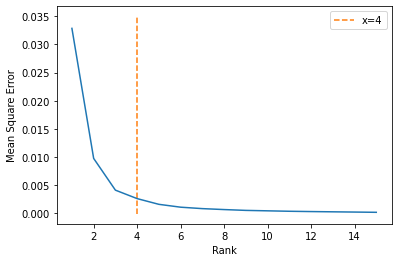

In [35]:
plt.plot(list(range(1,16)), test_errors)
plt.vlines(x=4,ymin=-0.0001,ymax=0.035, color="tab:orange", linestyle='dashed', label="x=4")
plt.xlabel("Rank")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()

In [36]:
test_ranker = 4

In [37]:
A,B = test_dset.sci_nmf(test_ranker, separate=True)
dotted_test = pd.DataFrame(np.dot(A,B))
dotted_test.index = test_dset.dataframe.index
dotted_test.columns = test_dset.dataframe.columns
test_nmf = mat_opr(dotted_test)

<AxesSubplot:title={'center':'Massachusetts Cases'}>

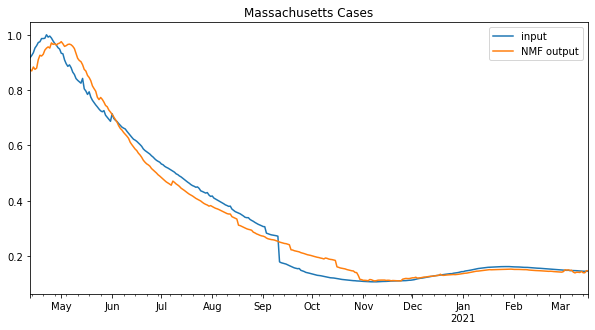

In [38]:
mass = pd.concat([test_dset.dataframe['Massachusetts'], test_nmf.dataframe['Massachusetts']], axis = 1)
mass.columns = ['input','NMF output']

mass.plot(kind = 'line',legend=True, title = 'Massachusetts Cases', figsize=(10,5))

## Determine best # of clusters

In [39]:
indexer_test = []
for i in range(test_ranker):
    indexer_test.append("basis " + str(i))

In [40]:
t_table = mat_opr(pd.DataFrame(B, index = indexer_test))
t_clust = np.transpose(np.array(t_table.array))

For n_clusters = 2 The average silhouette_score is : 0.4820668725929533
For n_clusters = 3 The average silhouette_score is : 0.44162815503089176
For n_clusters = 4 The average silhouette_score is : 0.3651833865555882
For n_clusters = 5 The average silhouette_score is : 0.3709060249285303


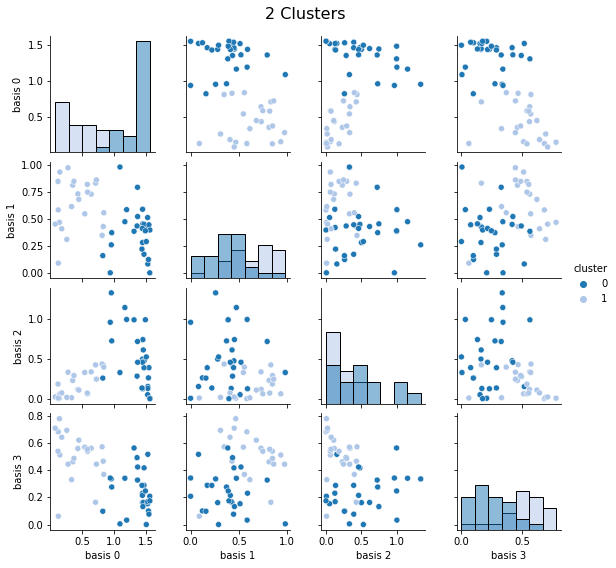

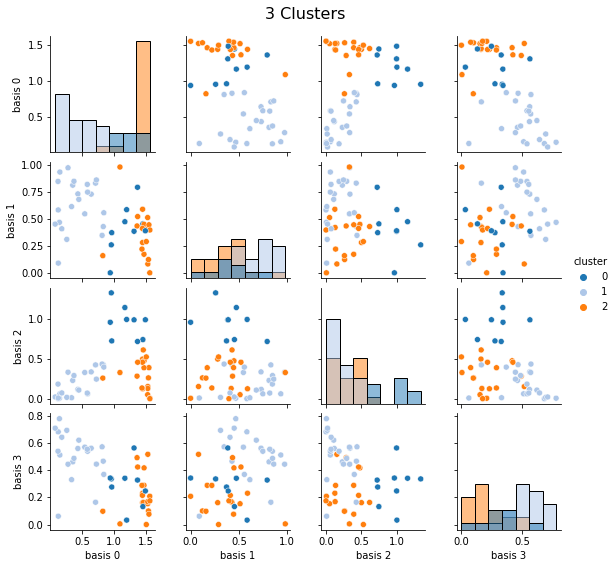

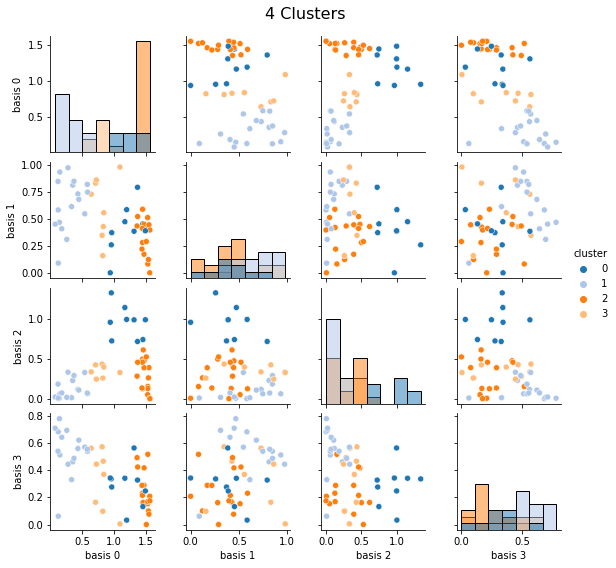

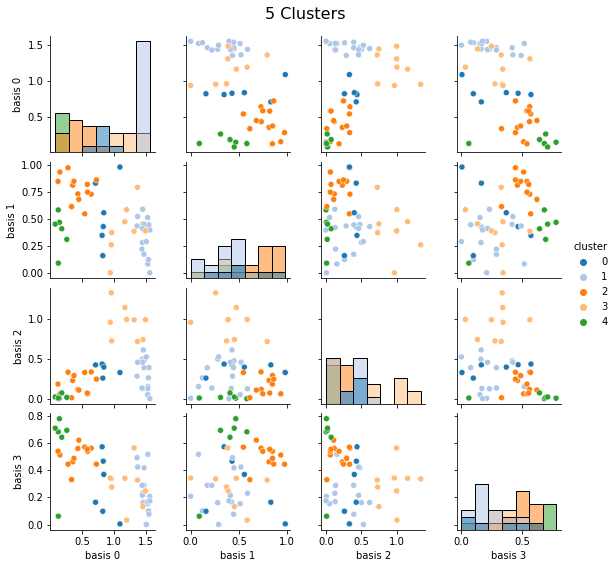

In [41]:
ns = [2,3,4,5]
t_silhouette = {}

for n in ns:
    kmeans = KMeans(n_clusters=n, random_state=9).fit(t_clust)
    n_counter = pd.Series(kmeans.labels_)
    
    silhouette_avg = silhouette_score(t_clust, n_counter)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    t_silhouette[n] = silhouette_avg
    
    n_cluster_df = t_table.dataframe.T
    n_cluster_df['cluster'] = n_counter

    pp = seaborn.pairplot(n_cluster_df, hue="cluster", diag_kind="hist", height=2, aspect=1, palette='tab20')
    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle(str(n) + " Clusters", fontsize=16)

In [42]:
t_clusters = max(t_silhouette, key=t_silhouette.get)
kmeans = KMeans(n_clusters=t_clusters, random_state=9).fit(t_clust)
count_test = pd.Series(kmeans.labels_)

### Pairwise distance Matrix:

In [43]:
# This takes a while because I did the simple O(n^2) implementation
t_input_pair_dist = test_dset.pairwise_distance()
t_factor_pair_dist =  t_table.pairwise_distance()

In [44]:
# rearrange pair_dist so that all columns/rows belonging to cluster 0 come before the ones correspoinding to cluster 1, etc.
# graph and expect to see small distance on the diagonals and larger everywhere else

t_input_pair_dist.columns = range(len(t_input_pair_dist.columns))

order = []
for h in range(t_clusters):
    order += count_test.loc[count_test == h].index.to_list()

t_input_pair_dist = t_input_pair_dist[order]
t_input_pair_dist = t_input_pair_dist.reindex(order)
t_factor_pair_dist = t_factor_pair_dist[order]
t_factor_pair_dist = t_factor_pair_dist.reindex(order)

In [45]:
count_test.value_counts()

0    28
1    23
dtype: int64

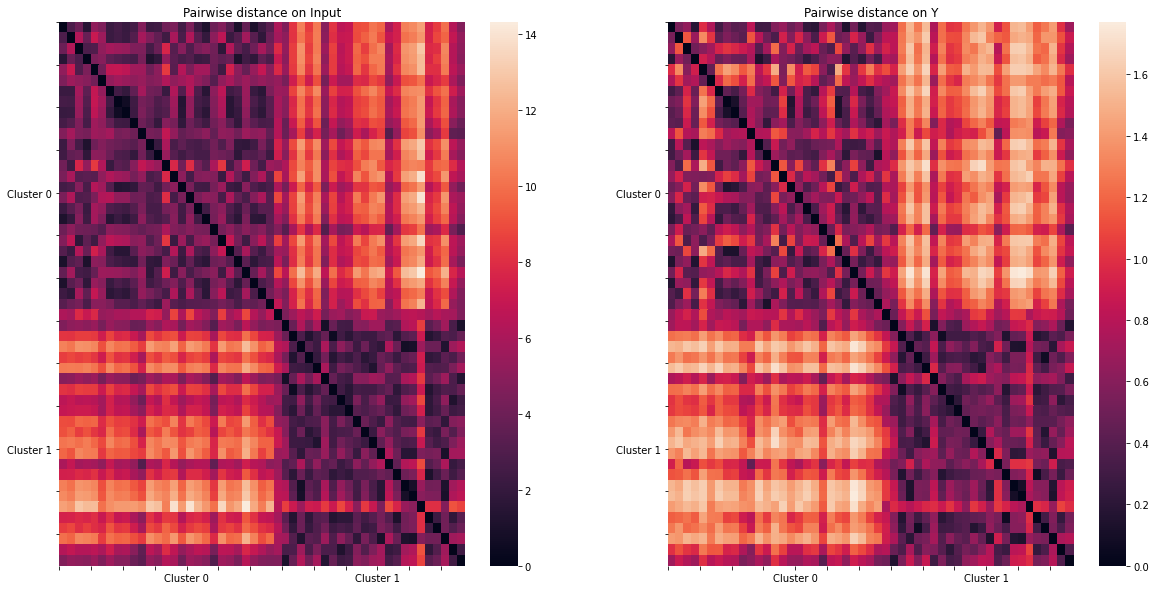

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
seaborn.heatmap(t_input_pair_dist, ax = ax1)
seaborn.heatmap(t_factor_pair_dist, ax = ax2)

# lot of work to get the x/yticks nice
tot = len(t_input_pair_dist.columns)
fracs = [va/tot for va in count_test.value_counts().to_list()]
l_m = round(np.lcm.reduce(count_test.value_counts().to_list())/tot)

for axy in [ax1, ax2]:
    axy.xaxis.set_major_locator(plt.MaxNLocator(l_m))
    axy.yaxis.set_major_locator(plt.MaxNLocator(l_m))

so_far = 0
labs = ['' for i in range(l_m)]
for f in range(len(fracs)):
    pos = round(l_m*(fracs[f]/2 + so_far))
    labs[pos] = 'Cluster ' + str(f)
    so_far += fracs[f]

ax1.set_xticklabels(labs, rotation= 0);
ax2.set_xticklabels(labs, rotation= 0);
ax1.set_yticklabels(labs);
ax2.set_yticklabels(labs);

ax1.set_title('Pairwise distance on Input');
ax2.set_title('Pairwise distance on Y');

## Cluster the vectors of Y after decomposition

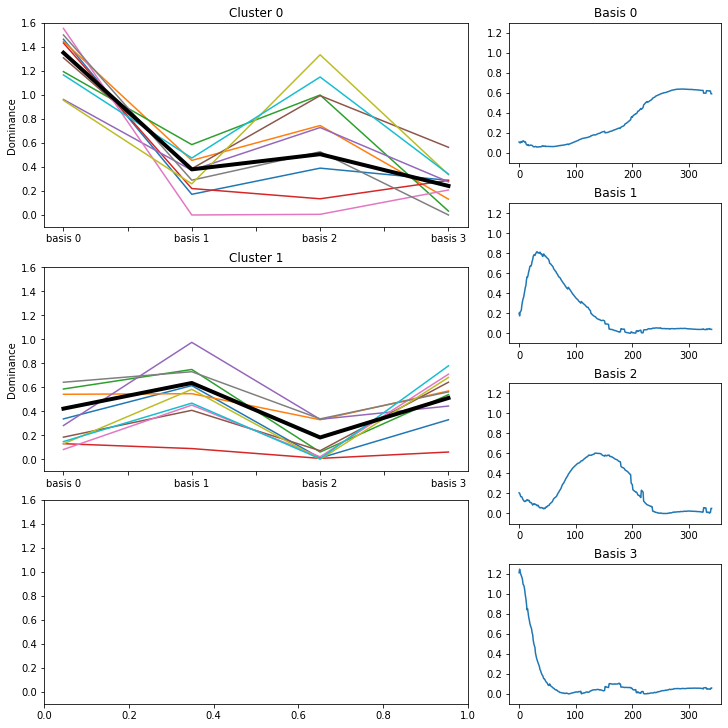

In [47]:
test_basis_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))

tgs = test_basis_fig.add_gridspec(12,3)
tbx1 = test_basis_fig.add_subplot(tgs[:4,0:2])
tbx2 = test_basis_fig.add_subplot(tgs[4:8,0:2])
tbx3 = test_basis_fig.add_subplot(tgs[8:12,0:2])
tbx4 = test_basis_fig.add_subplot(tgs[:3,2])
tbx5 = test_basis_fig.add_subplot(tgs[3:6,2])
tbx6 = test_basis_fig.add_subplot(tgs[6:9,2])
tbx7 = test_basis_fig.add_subplot(tgs[9:12,2])
plot_cluster(t_table, count_test, mean=True,axer=[tbx1, tbx2, tbx3],
            ylabel = "Dominance", ylimit = [-0.1,1.6])

baser = pd.DataFrame(A)
basis_subs = [tbx4, tbx5, tbx6, tbx7]
for b in baser.columns:
    baser[b].plot(ax = basis_subs[b], title="Basis " + str(b))
    basis_subs[b].set_ylim([-0.1,1.3])

### Plot test curves based on cluster of Y

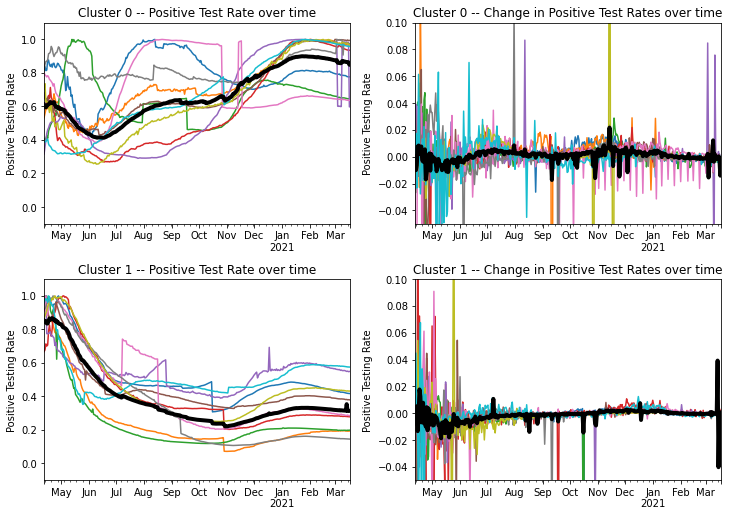

In [48]:
test_fig = plt.figure(1, constrained_layout=True, figsize = (10,10))
#ts = test_fig.add_gridspec(2,2)
ts = test_fig.add_gridspec(3,2)
tx1 = test_fig.add_subplot(ts[0,0])
tx2 = test_fig.add_subplot(ts[1,0])
tx3 = test_fig.add_subplot(ts[0,1])
tx4 = test_fig.add_subplot(ts[1,1])
#tx5 = test_fig.add_subplot(ts[2,0])
#tx6 = test_fig.add_subplot(ts[2,1])

plot_cluster(test_dset, count_test, mean=True,axer=[tx1, tx2], 
             ylabel = "Positive Testing Rate", title = "-- Positive Test Rate over time", ylimit=[-0.1,1.1])
plot_cluster(test_dset.new_case_calc(), count_test, mean=True, legend=False,axer=[tx3,tx4], ylabel = "Positive Testing Rate",
            title = "-- Change in Positive Test Rates over time", ylimit=[-0.05,0.1])
"""
plot_cluster(test_dset, count_test, mean=True,axer=[tx1, tx2,tx5], 
             ylabel = "Positive Testing Rate", title = "-- Positive Test Rate over time", ylimit=[-0.1,1.1])
plot_cluster(test_dset.new_case_calc(), count_test, mean=True, legend=False,axer=[tx3,tx4, tx6], ylabel = "Positive Testing Rate",
            title = "-- Change in Positive Test Rates over time")
"""
plt.show()

### Geographic correlation

In [49]:
cluster_by_test = {}
for c in count_test.index:
    t_name = test_dset.dataframe.iloc[:,c].name
    cluster_by_test[t_name] = count_test[c]

In [50]:
t_state_map = gp.read_file("US_States_geojson.json")

In [51]:
t_cluster_col = []
for i in t_state_map["NAME"]:
    try:
        t_cluster_col.append("Cluster " + str(cluster_by_test[i]))
    except:
        t_cluster_col.append(np.nan)

In [52]:
t_state_map['cluster'] = t_cluster_col

<AxesSubplot:>

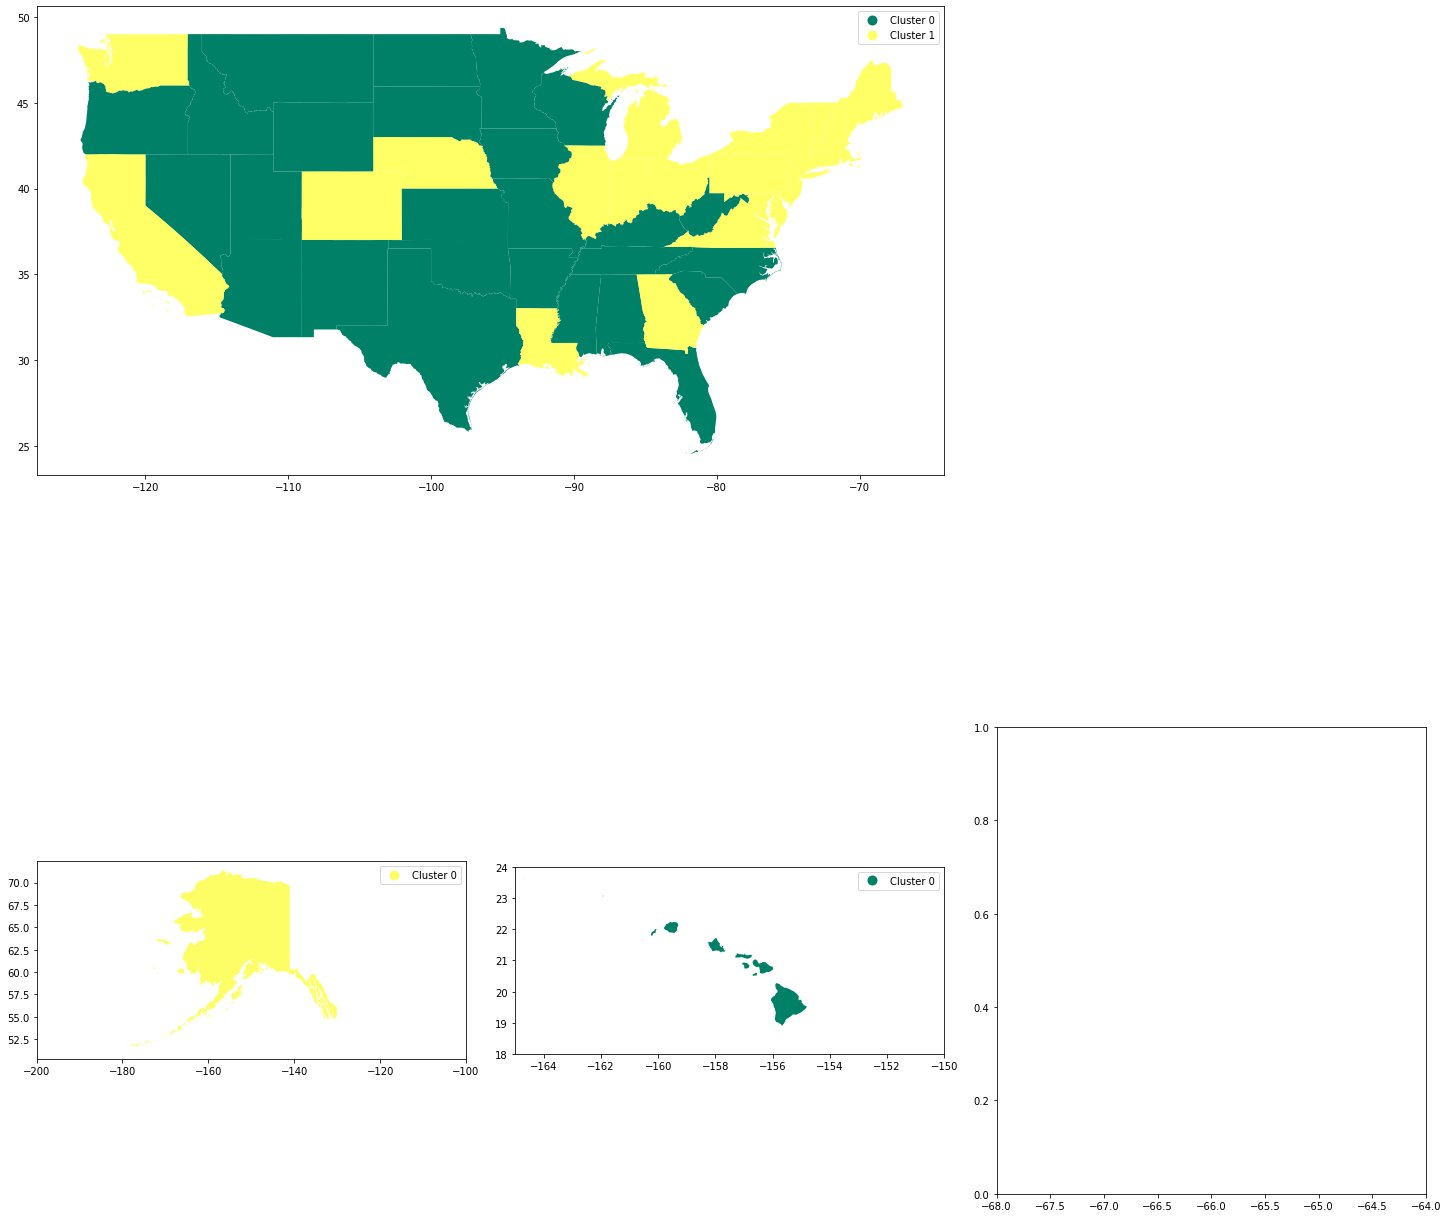

In [53]:
t_state_fig = plt.figure(1,constrained_layout=True, figsize=(20,20))
tss = t_state_fig.add_gridspec(3,3)
tsx1 = t_state_fig.add_subplot(tss[0:2,0:2])
tsx2 = t_state_fig.add_subplot(tss[2,0])
tsx2.set_xlim(-200,-100)
tsx3 = t_state_fig.add_subplot(tss[2,1])
tsx3.set_xlim(-165,-150)
tsx3.set_ylim(18,24)
tsx4 = t_state_fig.add_subplot(tss[2,2])
tsx4.set_xlim(-68,-64)

c0 = ListedColormap((0.0,0.5,0.4,1.0)) #dark green
c1 = ListedColormap((0.5019607843137255, 0.7509803921568627, 0.4, 1.0)) #lighter green
c2 = ListedColormap((0.9921568627450981, 0.996078431372549, 0.4, 1.0)) # yellow

#t_state_map[t_state_map['NAME'].isin(['Alaska','Hawaii','Puerto Rico']) == False].plot(column='cluster', 
t_state_map[t_state_map['NAME'].isin(['Alaska','Hawaii']) == False].plot(column='cluster',
ax=tsx1, legend=True, categorical=True, figsize=(60,60), cmap='summer')
t_state_map[t_state_map['NAME'] == 'Alaska'].plot(column='cluster', ax=tsx2, legend=True, categorical=True, figsize=(10,10), cmap=c2)
t_state_map[t_state_map['NAME']=='Hawaii'].plot(column='cluster', ax=tsx3, legend=True, categorical=True, figsize=(10,10), cmap=c0)
#t_state_map[t_state_map['NAME']=='Puerto Rico'].plot(column='cluster', ax=tsx4, legend=True, categorical=True, figsize=(10,10), cmap=c0)
